# Project for PML exam - PPCA 

### PCA standard approach - Dimensionality reduction & Data Visualization

First of all let's try to perform standard PCA on a dataset and see the results of applying this technique. 

We decided to use as dataset the Breast cancer dataset.

In [ ]:
!pip install pyro-ppl
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints
sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(0)

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [ ]:
X, y = datasets.load_breast_cancer(return_X_y = True)
dataset = datasets.load_breast_cancer()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)

#to give a little bit of context we can print the shapes of X and y 
print("Features {}".format(X.shape))
print("Target {}".format(y.shape))
print(df.head())

Features (569, 30)
Target (569,)
   mean radius  mean texture  ...  worst symmetry  worst fractal dimension
0        17.99         10.38  ...          0.4601                  0.11890
1        20.57         17.77  ...          0.2750                  0.08902
2        19.69         21.25  ...          0.3613                  0.08758
3        11.42         20.38  ...          0.6638                  0.17300
4        20.29         14.34  ...          0.2364                  0.07678

[5 rows x 30 columns]


In [ ]:
# After having loaded the dataset, and took a look at the dimensionality of that (30) 
# we can procede with a bit of preprocessing steps:
### we need to standardize the entire dataset since standardization helps 
### in dealing with the different scale issues present in the dataset 
### and so PCA can give much more effective results.

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
# then we can compute the covariance matrix which should have size DxD (D=30)
sample_data = X_std

c_matrix = np.matmul(sample_data.T , sample_data)
print ("The shape of variance matrix =", c_matrix.shape)

# then we can find the two largest eigenvalues and the corresponding eigenvectors
# since we'd like to project the dataset on a 2d principal subspace

from scipy.linalg import eigh

# eigh function will return the eigen values in asending order
# and so we pick only the top 2 (28 and 29) eigenvalues.
values, vectors = eigh(c_matrix, eigvals=(28,29))
print("Shape of eigen vectors =",vectors.shape)

# converting the eigen vectors into (2,D) shape for easyness of further computations
vectors = vectors.T
print("Updated shape of eigen vectors =",vectors.shape)
# here the vectors[1] represent the eigen vector corresponding 1st principal eigen vector
# here the vectors[0] represent the eigen vector corresponding 2nd principal eigen vector

The shape of variance matrix = (30, 30)
Shape of eigen vectors = (30, 2)
Updated shape of eigen vectors = (2, 30)


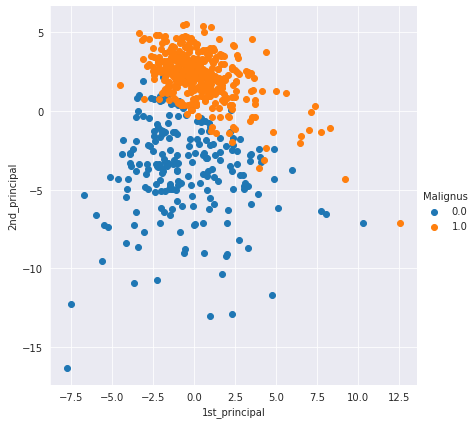

In [ ]:
# now we can visualize if the dataset has been separated using PCA

new_coordinates = np.matmul(vectors, sample_data.T)
labels = dataset['target']
new_coordinates = np.vstack((new_coordinates, labels)).T
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))

ax = sns.FacetGrid(dataframe, hue="label", height=6).map(plt.scatter, "1st_principal", "2nd_principal").add_legend(title='Malignus')

plt.show()

Since for this dataset the dimensionality is not that high, PCA is actually able to distinguish pretty well the labels but not to separate them. 

Now we can apply PCA using sklearn in order to perform dimensionality reduction and try to capture the effectiveness of this process.


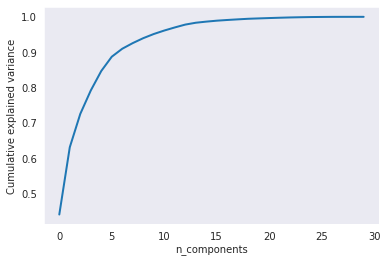

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA()
# PCA for dimensionality redcution
pca.n_components = 30
pca_data = pca.fit_transform(sample_data)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative explained variance')
plt.show()

With 5 components we are able to explain almost the 90% of the variability, which is a nice result w.r.t. using all the 30 components.

### A probabilistic approach - PPCA

Let's try to implement PPCA. What we need to do is to first define a model and a guide and then we can perform svi inference to find out suitable values for W, mu and sigma.

In [ ]:
M, D = 2, 30
def model(data):
    W = pyro.param("W", torch.zeros((D, M)))
    mu = pyro.param("mu", torch.zeros(D))
    sigma = pyro.param("sigma", torch.ones(1))

    for i in pyro.plate("data", len(data)):
        z = pyro.sample("latent_{}".format(i), dist.Normal(torch.zeros(M), 1.0).to_event(1))
        pyro.sample("observed_{}".format(i), dist.Normal(W@z + mu, sigma).to_event(1), obs=data[i])

def guide(data):
    W = pyro.param("W", torch.zeros((D, M)))
    for i in pyro.plate("data", len(data)):
        pyro.sample("latent_{}".format(i), dist.Normal(W.T@data[i], 1.0).to_event(1))

Step 0 : loss = 24221.280437469482
Step 100 : loss = 21580.995102643967
Step 200 : loss = 21578.249908089638
Step 300 : loss = 21531.48270392418
Step 400 : loss = 21650.652762174606
Step 500 : loss = 21588.768817305565
Step 600 : loss = 21659.45861887932
Step 700 : loss = 21560.939293384552
Step 800 : loss = 21608.91103041172
Step 900 : loss = 21594.963811278343


Text(0, 0.5, 'loss')

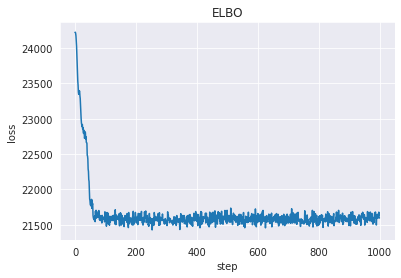

In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=optim.ClippedAdam({'lr' : 0.01}),
                     loss=Trace_ELBO())

X = torch.tensor(X_std, dtype=torch.float32)
losses = []
num_steps = 1000
for step in range(num_steps):
    loss = svi.step(X)
    losses.append(loss)
    if step % 100 == 0:
      print(f"Step {step} : loss = {loss}")

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [ ]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

Inferred params: ['W', 'mu', 'sigma']



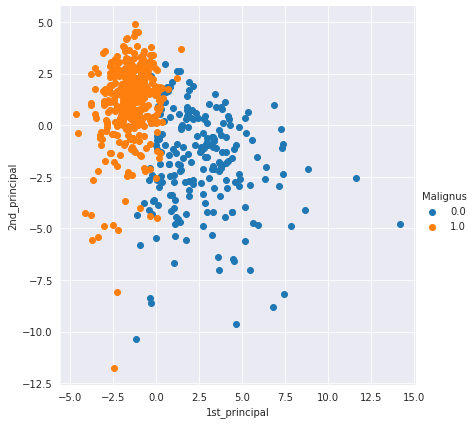

In [ ]:
prob_vectors = pyro.get_param_store()["W"].detach().numpy().T
new_coordinates = np.matmul(prob_vectors, sample_data.T)
new_coordinates = np.vstack((new_coordinates, labels)).T
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))

sns.FacetGrid(dataframe, hue="label", height=6).map(plt.scatter, "1st_principal", "2nd_principal").add_legend(title='Malignus')
plt.show()

Also in this case, using PPCA gives comparable results with the ones obtained using PCA. We can notice actually that the principal components chosen in this case seem to be different than before (look at the new axis orientation).

#### EM algorithm for PPCA

Instead of using Variational Inference to find out the optimal values for model parameters we can define an Expectation Maximization algorithm in order to find, iteratively, maximum likelihood estimates of those.

In [ ]:
# first step is to initialize, at random, the parameters we'd like to find
# the estimate. 
# From theory we already know that the ml solution for the mean is equal
# to the data mean, and so we can immediately retrieve it.

def EM_algo(X, L, D):
    mean = np.mean(X)
    W = np.random.rand(D, L)
    sigma = np.random.uniform(0,1)

    for i in range(100):
        # E-step
        M = (W.T).dot(W) + sigma * np.eye(L)
        M_inv = np.linalg.inv(M)
        zn_expectation = M_inv.dot(W.T).dot((X-mean).T)
        zn_zn_t_expectation = sigma*M_inv + zn_expectation.dot(zn_expectation.T)

        # M-step
        W_new = (((X-mean).T).dot(zn_expectation.T)).dot(np.linalg.inv(zn_zn_t_expectation))
        a = 2*np.trace((zn_expectation.T).dot(W_new.T).dot((X-mean).T))
        b = np.trace(zn_zn_t_expectation.dot((W_new.T).dot(W_new)))
        sigma_new = np.linalg.norm(X-mean) - a + b
        sigma_new = (1/(len(X)*D))*sigma_new
        W = W_new
        sigma = sigma_new

    return W, sigma, mean

In [ ]:
W_em, sigma_em, mu_em = EM_algo(X_std, 2, 30)

### Bayesian PCA

As discussed, we now try to apply a bayesian approach to determine M the dimension of the principal subspace using Bayesian methods. We maximize the evidence for the model which, using laplace's approximation, gives a formula for the value of $\alpha$. This maximization will send some of the $\alpha_i$ to inifinity which result in null eigenvectors, thus reducing the number of relevant vectors. 
This method is interleaved with the EM algorithm used above where we modify the M-Step accordingly and add the update for the $\alpha_i$ parameters.

In [ ]:
def bayesian_pca(X, L, D):
    mean = np.mean(X)
    W = np.random.rand(D, L)
    sigma = np.random.uniform(0,1)
    alpha = np.random.rand(L)
    W_new = np.random.rand(D, L)

    while (W-W_new).all() > 1e-15:
        W = W_new
        # E-step
        M = (W.T).dot(W) + sigma * np.eye(L)
        M_inv = np.linalg.inv(M)
        zn_expectation = M_inv.dot(W.T).dot((X-mean).T)
        zn_zn_t_expectation = sigma*M_inv + zn_expectation.dot(zn_expectation.T)

        # M-step
        W_new = (((X-mean).T).dot(zn_expectation.T)).dot(np.linalg.inv(zn_zn_t_expectation+sigma*np.diag(alpha)))
        a = 2*np.trace((zn_expectation.T).dot(W_new.T).dot((X-mean).T))
        b = np.trace(zn_zn_t_expectation.dot((W_new.T).dot(W_new)))
        sigma_new = np.linalg.norm(X-mean) - a + b
        sigma_new = (1/(len(X)*D))*sigma_new
        #W = W_new
        sigma = sigma_new
        alpha = D/np.diagonal(((W_new.T).dot(W_new)))

    return W, sigma, mean, alpha

In [ ]:
*_, alpha =  bayesian_pca(X_std, 29, 30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
alpha

array([1.18017653e-03, 1.86024187e-03, 1.38401865e-01, 9.33096780e+06,
       5.05382704e-03, 1.15790052e-02, 1.45961537e-03, 3.54820295e-02,
       1.06976832e-02, 1.32505570e-02, 7.84162797e-04, 2.99461647e-03,
       1.04144314e-02, 1.63921606e-03, 1.26764230e-03, 1.24065350e-02,
       1.69567553e-03, 1.25783655e-03, 8.58064085e-04, 1.30155939e-01,
       4.59237579e-03, 1.56473895e-02,            inf, 4.18964061e-02,
       1.67570955e-02, 5.33172965e-03, 2.72438507e-03, 1.94834724e-02,
                  inf])

As we can see, some of the $\alpha_i$ parameters have been driven to inifinity as expected which tells us that the eigenvectors corresponding to those eigenvalues are null and don't contribute to identifying a principal subspace. 

### Kernel PCA

To start we write our own implementation of kernel PCA using the radial basis kernel. 
Following the lines of the theory, we first need to calculate the gram-matrix which the kernel operator and then center it using the proper formula. 
Subsequently, we find the eigenvalues and eigenvectors of the kernel operator and return the first "n_components" we are interested in (given as input).
It is useful to remember that the j-th component of the i-th eigenvector (which has lenght N) is the projection of the j-th point unto the same vector. In other words, the eigenvectors are the projections themselves. 

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np 
import matplotlib.pyplot as plt


def kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.    
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [N-samples, D-dimensions/features]  
    gamma: float
        RBF kernel parameter 
    n-components: int
      Dimensionality of feature space    
    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [N, n-component]
        Projected dataset   
    """
    # Calculate pairwise squared Euclidean distances
    # in the NxD dimensional dataset.
    dist = pdist(X, 'sqeuclidean')    
    # Convert pairwise distances into a square matrix.
    squared_mat = squareform(dist)    
    # Compute the symmetric kernel matrix.
    K = exp(-gamma * squared_mat)    
    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)    
   
    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                           for i in range(n_components)])    
    print(X_pc.shape)
    return X_pc

Now we import the make_moons dataset which we know to be very nonlinear and thus not suited for standard PCA. Below is the plot of the dataset:

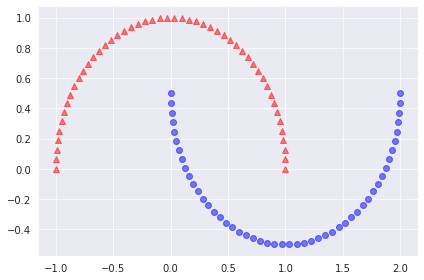

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

As we can see, standard PCA wouldn't work since the data set is highly nonlinear and any direction it may find for the principal subspace would be ineffective at reducing the dimensionality (as shown below) because we would have overlap and lose information. 

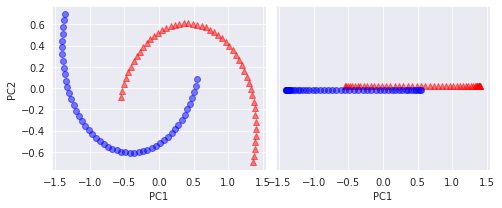

In [ ]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)

X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)

ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y==0, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)

ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')

ax[0].set_ylabel('PC2')

ax[1].set_ylim([-1, 1])

ax[1].set_yticks([])

ax[1].set_xlabel('PC1')

plt.tight_layout()

plt.show()

As we can see, standard PCA proves to be ineffective at reducing the dimensionality of this data set as shown by the overlap of red and blue points. This is not something we want as we want to preserve as much as we can the information from the original data set and be able to say, pass it to a classifier or something (or even do some data visualization).

Now we test our own implementation of Kernel PCA to see what happens.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead


(100, 2)


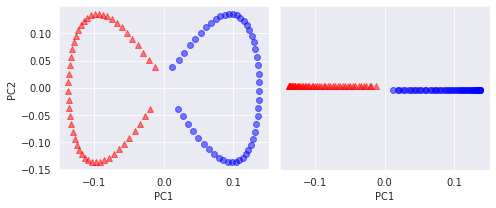

In [ ]:
X_kpca = kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()


As we can see, this method is much more effective in reducing the dataset to a single coordinate, however, it is important to note that the space has changed and we are no longer in the "original" space. This is because we are working with the coordinates in the new space induced by $\phi$.

As a last thing, we test our own implementation against the implementation provided by sklearn in order to ensure that it behaves in the same way and that everything was indeed done correctly. 

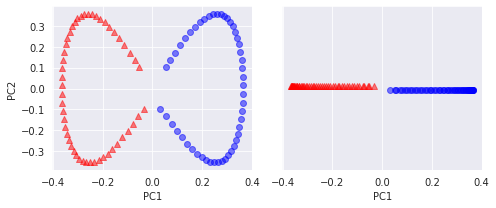

In [ ]:
from sklearn import cluster
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 15)
X_kpca = kpca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.tight_layout()
plt.show()

As we can see, the results match perfectly. 

We now study Kernel PCA in light of another example to gain a little more intuition.

We analyze the make_circles dataset which inherently presents a very high nonlinearity. 

Below is the dataset:

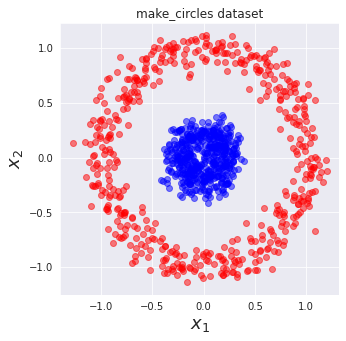

In [ ]:
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
reds = y == 0
blues = y == 1

plt.figure(figsize=(5,5))
plt.plot(X[reds, 0], X[reds, 1], "ro", alpha=0.5)
plt.plot(X[blues, 0], X[blues, 1], "bo", alpha=0.5)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18)
plt.title("make_circles dataset")
_=0


In [ ]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=15)
X_kpca = kpca.fit_transform(X) #kernel pca to feature space
X_back = kpca.inverse_transform(X_kpca) #inverse transformation of kernel pca
pca = PCA() #standard pca 
X_pca = pca.fit_transform(X)

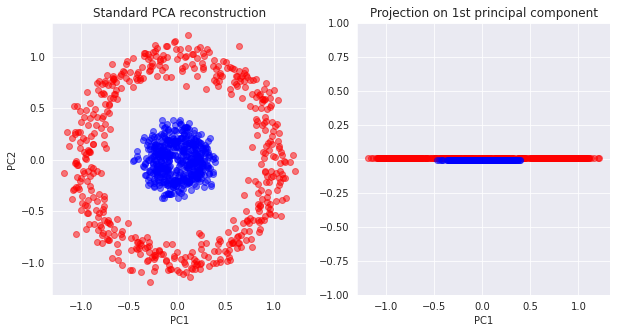

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].scatter(X_pca[reds, 0], X_pca[reds, 1], color='red', marker='o', alpha=0.5)
ax[0].scatter(X_pca[blues, 0], X_pca[blues, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_pca[reds, 0], np.zeros((500,1))+0.01, color='red', marker='o', alpha=0.5)
ax[1].scatter(X_pca[blues, 0], np.zeros((500,1))-0.01, color='blue', marker='o', alpha=0.5)
ax[0].set_title("Standard PCA reconstruction")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")
ax[1].set_ylim([-1, 1])
ax[1].set_title("Projection on 1st principal component")


ax[1].set_xlabel("PC1")

_= 0

As we can see, standard PCA can reconstruct the dataset but its obviously not well suited for dimensionality reduction or image visualization.

Now we show the outcome for kernel PCA:

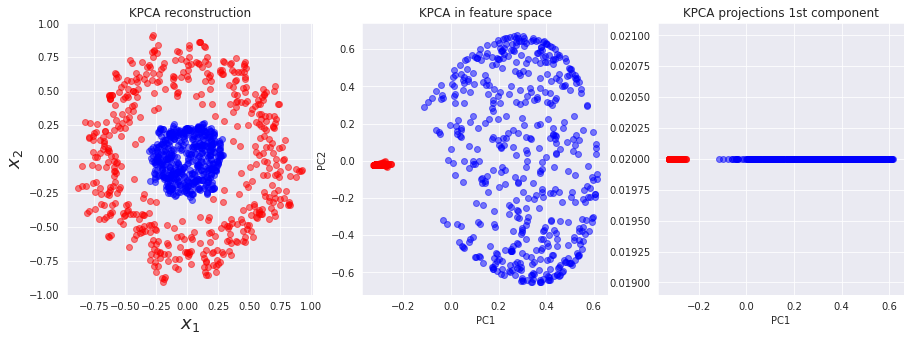

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].plot(X_back[reds, 0], X_back[reds, 1], "ro", alpha=0.5)
ax[0].plot(X_back[blues, 0], X_back[blues, 1], "bo", alpha=0.5)
ax[0].set_title("KPCA reconstruction")
ax[0].set_xlabel("$x_1$",fontsize=18)
ax[0].set_ylabel("$x_2$", fontsize=18)

ax[1].plot(X_kpca[reds, 0], X_kpca[reds, 1], "ro", alpha=0.5)
ax[1].plot(X_kpca[blues, 0], X_kpca[blues, 1], "bo", alpha=0.5)
ax[1].set_title("KPCA in feature space")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

ax[2].plot(X_kpca[reds, 0], np.zeros((500,1))+0.02, "ro", alpha=0.5)
ax[2].plot(X_kpca[blues, 0], np.zeros((500,1))+0.02, "bo", alpha=0.5)
ax[2].set_title("KPCA projections 1st component")
ax[2].set_xlabel("PC1")
_=0

As we can see, this method is much more suited to provide proper separation of the dataset although we are in a different space.

## References
Christopher M. Bishop: "Pattern recognition and Machine learning", pp. 559-591.

David J.C. MacKay: "[Probable networks and plausible predictions - a review of practical Bayesian methods for supervised newural networks](http://www.inference.org.uk/mackay/network.pdf)".

Michael E. Tipping, Christopher M. Bishop: "[Probabilistic principal component analysis](http://www.cs.columbia.edu/~blei/seminar/2020-representation/readings/TippingBishop1999.pdf)".
